# 🎶 Análisis de Sentimiento de Artistas a partir de la API de Last.fm

## Global Project - Máster en Data Science - IEBS
## Recomendador-Eventos-Musicales

Este notebook tiene como objetivo realizar un análisis de sentimiento sobre artistas musicales
utilizando las etiquetas generadas por la comunidad de usuarios en Last.fm. 

La información se integrará con una colección propia en MongoDB como parte de un sistema de recomendación
musical desarrollado en el marco del Global Project del Máster.

## 1. Consulta de etiquetas desde la API de Last.fm

En esta sección conectamos con la API pública de Last.fm utilizando las credenciales definidas en el fichero `.env`.

Utilizaremos el método `artist.getTopTags`, que devuelve las etiquetas más populares asociadas a un artista según las valoraciones de la comunidad.

Estas etiquetas servirán como proxy del sentimiento asociado al artista.

### 1.1. Importación de librerias necesarias

In [133]:
# Importación de librerías necesarias
import os
import requests
import json
from dotenv import load_dotenv

### 1.2. Consulta de etiquetas desde la API

En este bloque realizamos la conexión con la API de Last.fm para obtener información sobre los artistas musicales.

El proceso se divide en dos partes:
1. Acceso a la API mediante credenciales seguras almacenadas en el archivo `.env`.
2. Función personalizada para obtener las etiquetas (`tags`) más representativas asociadas a un artista concreto.

1. Acceso a la API mediante credenciales seguras almacenadas en el archivo `.env`.

In [134]:
# Cargar las variables de entorno desde el archivo .env
load_dotenv()

# Recuperar claves de la API (limpiando las comillas si existen)
API_KEY = os.getenv("API_KEY_LASTFM").strip('"')
USER_LASTFM = os.getenv("USER_LASTFM").strip('"')

# Verificación
print("✅ Credenciales cargadas correctamente.")

✅ Credenciales cargadas correctamente.


2. Función personalizada para obtener las etiquetas (`tags`) más representativas asociadas a un artista concreto.

In [135]:
def get_artist_tags(artist_name):
    url = "http://ws.audioscrobbler.com/2.0/"
    params = {
        "method": "artist.getTopTags",
        "artist": artist_name,
        "api_key": API_KEY,
        "format": "json"
    }
    response = requests.get(url, params=params)
    return response.json()

### 1.3. Consulta ejemplo con un artista

Aquí podemos ver y analizar el tipo de estructura obtenida en el Json para cada etiqueta.

In [136]:
# Prueba con un artista concreto
resultado = get_artist_tags("GunsnRoses")

# Mostrar el resultado formateado para análisis
print(json.dumps(resultado, indent=2))

{
  "toptags": {
    "tag": [
      {
        "count": 100,
        "name": "hard rock",
        "url": "https://www.last.fm/tag/hard+rock"
      },
      {
        "count": 70,
        "name": "rock",
        "url": "https://www.last.fm/tag/rock"
      },
      {
        "count": 55,
        "name": "classic rock",
        "url": "https://www.last.fm/tag/classic+rock"
      },
      {
        "count": 38,
        "name": "80s",
        "url": "https://www.last.fm/tag/80s"
      },
      {
        "count": 23,
        "name": "metal",
        "url": "https://www.last.fm/tag/metal"
      },
      {
        "count": 11,
        "name": "heavy metal",
        "url": "https://www.last.fm/tag/heavy+metal"
      },
      {
        "count": 11,
        "name": "seen live",
        "url": "https://www.last.fm/tag/seen+live"
      },
      {
        "count": 5,
        "name": "Guns N Roses",
        "url": "https://www.last.fm/tag/Guns+N+Roses"
      },
      {
        "count": 5,
        "nam

## 2. Preparación del texto para el análisis de sentimiento

En este paso transformamos las etiquetas (`tags`) extraídas desde la API en un único texto plano que pueda ser interpretado por una herramienta de análisis de sentimiento.

Este texto se compone de las etiquetas más representativas del artista, eliminando aquellas que no aportan información valiosa o que son demasiado genéricas (como `seen live`, `favorites`, etc.).

### 2.1. Importación de librerias necesarias

In [137]:
import unicodedata

### 2.2. Extracción de texto plano a partir de las etiquetas (`tags`) de Last.fm.
Extrae un texto plano a partir de las etiquetas de Last.fm, excluyendo términos poco informativo o repetidos que incluyan el nombre del artista.

In [138]:
# Normaliza texto para comparación interna, pero no altera el valor original que se guarda.
def normalizar_para_comparar(texto):
    texto = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('utf-8')
    return texto.lower().replace(" ", "").replace("'", "").replace("&", "and")

# Devuelve un string con las etiquetas principales del artista, limpiando las irrelevantes, pero preservando el formato original de las etiquetas válidas.
def extraer_tags_como_texto(tags_json, top_n=10, excluir_comunes=True):

    try:
        tags = tags_json.get('toptags', {}).get('tag', [])
        artist_name_raw = tags_json.get('toptags', {}).get('@attr', {}).get('artist', '')
        artist_name_clean = normalizar_para_comparar(artist_name_raw)

        comunes = {"seen live", "favorites", "00s", "90s", "80s", "70s", "british", "beautiful", "best"}

        tag_names = []
        for tag in tags[:top_n]:
            name = tag.get("name", "").strip()
            if not name:
                continue
            name_lower = name.lower()
            if excluir_comunes and name_lower in comunes:
                continue
            if artist_name_clean in normalizar_para_comparar(name):
                continue
            tag_names.append(name)  # <- aquí conservamos el valor original

        texto_tags = " ".join(tag_names).strip()
        return texto_tags

    except Exception as e:
        print("⚠️ Error al procesar los tags:", e)
        return ""

### 2.3. Consulta ejemplo con un artista

Aquí podemos ver y analizar el tipo de estructura obtenida en el Json para cada etiqueta.

In [139]:
texto_tags = extraer_tags_como_texto(resultado)
print("Texto generado con etiquetas para análisis de sentimiento:")
print(texto_tags)

Texto generado con etiquetas para análisis de sentimiento:
hard rock rock classic rock metal heavy metal american hair metal


## 3. Análisis de sentimiento con TextBlob

En este paso aplicamos un análisis de sentimiento sencillo utilizando la librería `TextBlob`.

El texto de entrada está compuesto por las etiquetas más representativas del artista en Last.fm.

La librería devuelve una puntuación de `polaridad` que va desde -1 (muy negativo) a 1 (muy positivo).
Con base en esa polaridad, se clasifica el sentimiento general como positivo, neutro o negativo.

### 3.1. Importación de librerias necesarias

In [140]:
from textblob import TextBlob

### 3.2. Función de análisis de sentimiento
Analiza el sentimiento del texto proporcionado.
    
Retorna:
- Polaridad (float entre -1 y 1)
- Interpretación cualitativa

In [141]:
def analizar_sentimiento(texto):
    if texto:
        blob = TextBlob(texto)
        polaridad = blob.sentiment.polarity

        if polaridad > 0.2:
            interpretacion = "😊 Positivo"
        elif polaridad < -0.2:
            interpretacion = "😠 Negativo"
        else:
            interpretacion = "😐 Neutro"

        return polaridad, interpretacion
    else:
        return 0.0, "Sin texto para analizar"

### 3.3. Consulta ejemplo con un artista

In [142]:
# Asumimos que texto_tags viene de la función anterior
print("Texto para analizar:")
print(texto_tags)

polaridad, resultado_sentimiento = analizar_sentimiento(texto_tags)
print(f"\n📊 Resultado del análisis de sentimiento:")
print(f"Polaridad: {polaridad}")
print(f"Sentimiento: {resultado_sentimiento}")

Texto para analizar:
hard rock rock classic rock metal heavy metal american hair metal

📊 Resultado del análisis de sentimiento:
Polaridad: -0.08125000000000002
Sentimiento: 😐 Neutro


El análisis de sentimiento sobre las etiquetas asociadas al artista indica una percepción general neutra por parte de la comunidad.

## 4. Integración del resultado de sentimiento en la colección de MongoDB

En este paso conectamos con la base de datos y actualizamos la colección `artists`,
añadiendo el campo `sentiment` (valor textual: positivo / neutro / negativo) y el campo `polarity` (valor numérico).

De esta forma, este análisis de sentimiento y futuros análisis quedan reflejados en la base de datos y puede ser consultado o visualizado desde otras herramientas (ej. bot de Telegram).

### 4.1. Importación de librerias necesarias

In [143]:
import os
import sys

# Subir un nivel desde analysis_023 para llegar a la raíz del proyecto
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
# Añadir la raíz del proyecto a sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

from database_022.mongodb_connection import connect_to_mongodb_database
import unicodedata

# Librerias para visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### 4.2. Conexión con MongoDB y guardado

In [144]:
# Conectar con MongoDB
db = connect_to_mongodb_database()
artists_collection = db["artists"]

In [145]:
def normalizar_para_comparar(texto):
    texto = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('utf-8')
    return texto.lower().replace(" ", "").replace("'", "").replace("&", "and")

def guardar_sentimiento_en_mongo(artist_name, sentiment_text, polarity_value):
    """
    Busca el artista por coincidencia normalizada (solo para comparar),
    y actualiza su sentimiento sin modificar su nombre original.
    """
    nombre_normalizado = normalizar_para_comparar(artist_name)

    # Recorremos todos los artistas y comparamos nombre normalizado
    for artista in artists_collection.find():
        nombre_en_mongo = artista.get("artist", "")
        if normalizar_para_comparar(nombre_en_mongo) == nombre_normalizado:
            result = artists_collection.update_one(
                {"_id": artista["_id"]},
                {"$set": {
                    "sentiment": sentiment_text,
                    "polarity": polarity_value
                }}
            )
            print(f"✅ Sentimiento guardado correctamente para '{nombre_en_mongo}'")
            return

    print(f"⚠️ No se encontró el artista '{artist_name}' (ni siquiera normalizado)")

### 4.3. Consulta ejemplo con un artista

In [146]:
# Nombre exacto como esté en MongoDB
nombre_artista = "Guns N' Roses"

# Guardamos el análisis anterior
guardar_sentimiento_en_mongo(nombre_artista, resultado_sentimiento, polaridad)

✅ Sentimiento guardado correctamente para 'Guns N' Roses'


### 4.4. Análisis en lote de toda la colección de artistas

A continuación se realiza el análisis de sentimiento para todos los artistas de la colección `artists`.
Para cada uno, se extraen etiquetas desde la API de Last.fm, se genera un texto representativo, se evalúa el sentimiento, y se guarda el resultado en MongoDB.

Este paso automatiza el proceso de enriquecimiento de datos, permitiendo actualizar de forma masiva y replicable toda la base de artistas.

In [147]:
# Inicializar contadores y listas
total_artistas = 0
procesados_ok = 0
sin_etiquetas = 0

artistas_ok = []
artistas_sin_etiquetas = []

# Mostrar cuántos documentos tienen el campo "artist" en MongoDB
mongo_con_artist = artists_collection.count_documents({"artist": {"$exists": True}})
print(f"🔎 Artistas con campo 'artist' en MongoDB: {mongo_con_artist}")

# Recorre todos los artistas de MongoDB y actualiza sentimiento
for artista in artists_collection.find():
    nombre_original = artista.get("artist", "")
    if not nombre_original:
        continue  # ignora los que no tienen campo "artist"

    total_artistas += 1

    try:
        tags_json = get_artist_tags(nombre_original)
        texto_tags = extraer_tags_como_texto(tags_json)

        if not texto_tags:
            artistas_sin_etiquetas.append(nombre_original)
            sin_etiquetas += 1
            continue

        polaridad, sentimiento = analizar_sentimiento(texto_tags)
        guardar_sentimiento_en_mongo(nombre_original, sentimiento, polaridad)

        artistas_ok.append(nombre_original)
        procesados_ok += 1

    except Exception as e:
        artistas_sin_etiquetas.append(nombre_original)
        sin_etiquetas += 1

🔎 Artistas con campo 'artist' en MongoDB: 83
✅ Sentimiento guardado correctamente para 'Elefante'
✅ Sentimiento guardado correctamente para 'Lun8'
✅ Sentimiento guardado correctamente para 'Morad'
✅ Sentimiento guardado correctamente para 'Marco Mengoni'
✅ Sentimiento guardado correctamente para 'Walls'
✅ Sentimiento guardado correctamente para 'Counting Crows'
✅ Sentimiento guardado correctamente para 'Jack & Jack'
✅ Sentimiento guardado correctamente para 'Big Time Rush'
✅ Sentimiento guardado correctamente para 'Tedua'
✅ Sentimiento guardado correctamente para 'OneRepublic'
✅ Sentimiento guardado correctamente para 'Lady Gaga'
✅ Sentimiento guardado correctamente para 'Nick Mulvey'
✅ Sentimiento guardado correctamente para 'Residente'
✅ Sentimiento guardado correctamente para 'The Brian Jonestown Massacre'
✅ Sentimiento guardado correctamente para 'Toquinho'
✅ Sentimiento guardado correctamente para 'Bright Eyes'
✅ Sentimiento guardado correctamente para 'Dano'
✅ Sentimiento guardad

Vemos como ha ido actualizando cada artista de la base de datos de MongoDB con las nuevas etiquetas de polaridad y sentimiento, esto nos puede dar una idea de si esta haciendo bien el ejercicio pero pasemos a analizar los resultados.

### 4.5 Interpretación de resultados y visualización del análisis de sentimiento

In [148]:
# Mostrar resultados agrupados de artistas con sentimiento asignado
print("\n✅ Artistas actualizados con sentimiento:")
for nombre in artistas_ok:
    print(f" - {nombre}")
print(f"\n🔢 Total actualizados correctamente: {procesados_ok}")


✅ Artistas actualizados con sentimiento:
 - Elefante
 - Lun8
 - Morad
 - Marco Mengoni
 - Walls
 - Counting Crows
 - Jack & Jack
 - Big Time Rush
 - Tedua
 - OneRepublic
 - Lady Gaga
 - Nick Mulvey
 - Residente
 - The Brian Jonestown Massacre
 - Toquinho
 - Bright Eyes
 - Dano
 - Maya Hawke
 - Guns N' Roses
 - The Hives
 - AC/DC
 - Raule
 - Stray Kids
 - Gloosito
 - MANÁ
 - Monica Naranjo
 - Paulo Londra
 - Inhaler
 - Jessie Reyez
 - The Corrs
 - The Lumineers
 - Tom Odell
 - Julia Sabaté
 - Twenty One Pilots
 - GHOST
 - Mumford & Sons
 - Sematary
 - Wave To Earth
 - Fangoria
 - Erreway
 - La Femme
 - Imagine Dragons
 - James Arthur
 - Ed Sheeran
 - Lionel Richie
 - Tamino
 - Pixies
 - Weezer
 - Only the Poets
 - Queen Extravaganza
 - Duki
 - Diego Torres
 - AURORA
 - Dua Lipa
 - Delaporte
 - Camila Cabello
 - Tate McRae
 - WARHAUS
 - Robert Plant
 - Rei
 - The Midnight
 - HAUSER
 - Billie Eilish
 - Post Malone
 - Rauw Alejandro
 - Peso Pluma
 - Luka Sulic
 - Dead Poet Society
 - Jami

In [149]:
# Mostrar resultados de artistas sin asignación
print("\n⚠️ Artistas sin etiquetas asignadas:")
for nombre in artistas_sin_etiquetas:
    print(f" - {nombre}")
print(f"\n🔢 Total sin etiquetas: {sin_etiquetas}")


⚠️ Artistas sin etiquetas asignadas:
 - Hans Zimmer in Symphony
 - Basshall Movement
 - CA7RIEL / PACO AMOROSO
 - Mad Cool Festival
 - SMusic Festival
 - The Alan Parsons Live Project
 - Primavera Pop
 - Energy Fest
 - Matinee Gold

🔢 Total sin etiquetas: 9


In [150]:
# Resumen final
print("\n📊 Resumen global del análisis de sentimiento:")
print(f"✅ Con sentimiento añadido: {procesados_ok} artistas")
print(f"⚠️ Sin etiquetas o error: {sin_etiquetas} artistas")
print(f"🎵 Total artistas válidos encontrados: {total_artistas}")


📊 Resumen global del análisis de sentimiento:
✅ Con sentimiento añadido: 74 artistas
⚠️ Sin etiquetas o error: 9 artistas
🎵 Total artistas válidos encontrados: 83


In [151]:
print("📁 Total documentos en MongoDB:", artists_collection.count_documents({}))

📁 Total documentos en MongoDB: 83


Comprobamos que los artistas revisados coinciden con el total de artistas de la colección "artists" de MongoDB

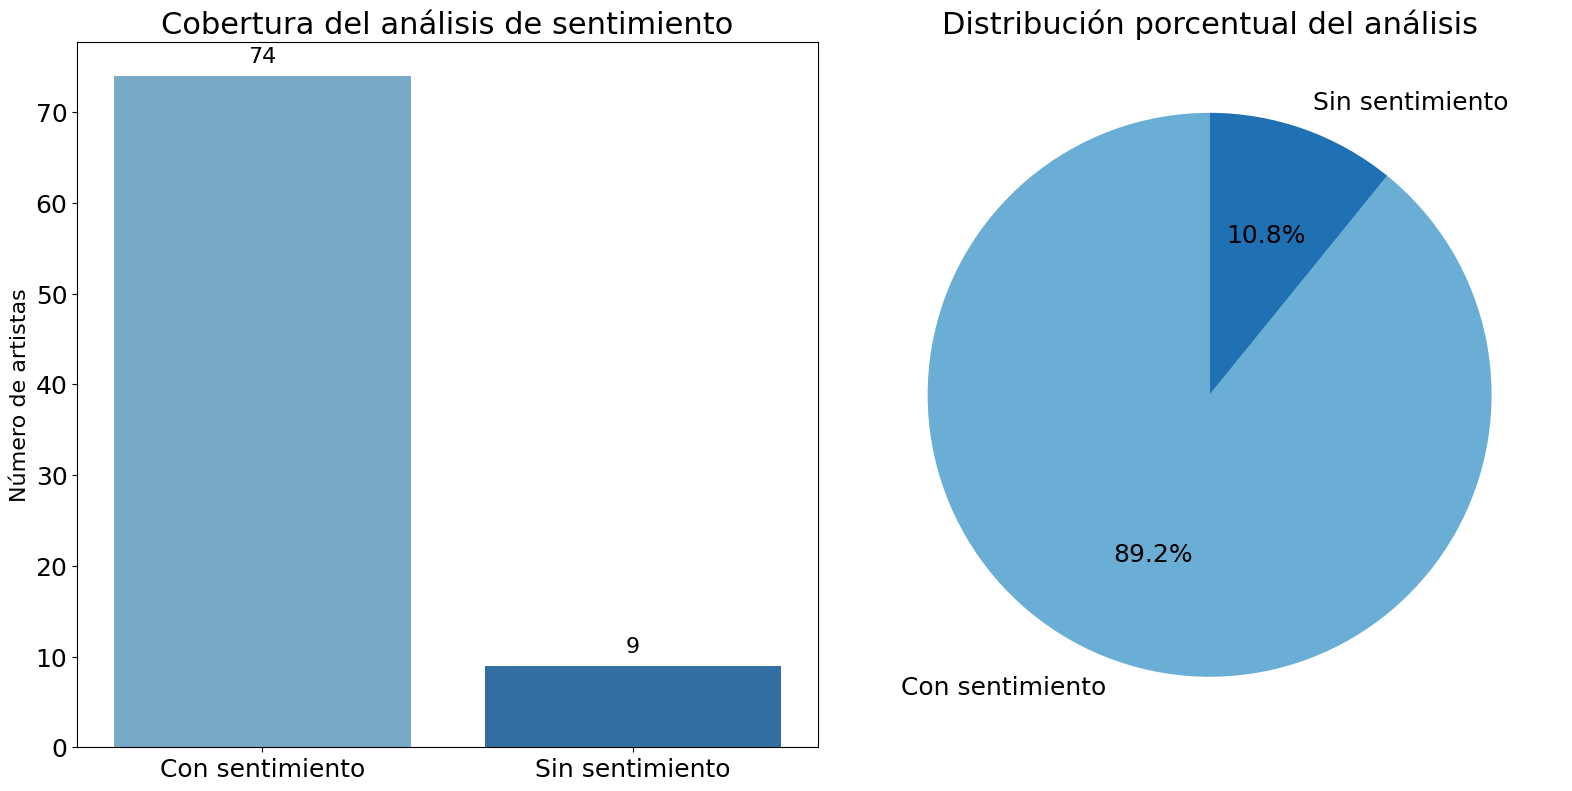

In [152]:
# Datos
etiquetas = ['Con sentimiento', 'Sin sentimiento']
valores = [procesados_ok, sin_etiquetas]
porcentajes = [v / total_artistas * 100 for v in valores]

# DataFrame
datos_sentimiento = pd.DataFrame({
    'Resultado': etiquetas,
    'Artistas': valores
})

# Paleta azul
colores = sns.color_palette("Blues", n_colors=3)[1:]

# Tamaños personalizados
fig_ancho = 16
fig_alto = 8
fontsize_titulo = 22
fontsize_ejes = 16
fontsize_etiquetas = 18
fontsize_pie = 18
fontsize_anotaciones = 16

# Crear figura grande
plt.figure(figsize=(fig_ancho, fig_alto))

# Subplot 1: Barras
plt.subplot(1, 2, 1)
barplot = sns.barplot(data=datos_sentimiento, x='Resultado', y='Artistas',
                      hue='Resultado', palette=colores, legend=False)

# Etiquetas grandes en las barras
for p in barplot.patches:
    barplot.annotate(f'{int(p.get_height())}', 
                     (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                     ha='center', va='bottom', fontsize=fontsize_anotaciones)

# Estilo gráfico de barras
plt.title('Cobertura del análisis de sentimiento', fontsize=fontsize_titulo)
plt.ylabel('Número de artistas', fontsize=fontsize_ejes)
plt.xlabel('', fontsize=fontsize_ejes)
plt.xticks(fontsize=fontsize_etiquetas)
plt.yticks(fontsize=fontsize_etiquetas)

# Subplot 2: Pastel
plt.subplot(1, 2, 2)
plt.pie(valores, labels=etiquetas, autopct='%1.1f%%', startangle=90,
        colors=colores, textprops={'fontsize': fontsize_pie})
plt.title('Distribución porcentual del análisis', fontsize=fontsize_titulo)

plt.tight_layout()
plt.show()

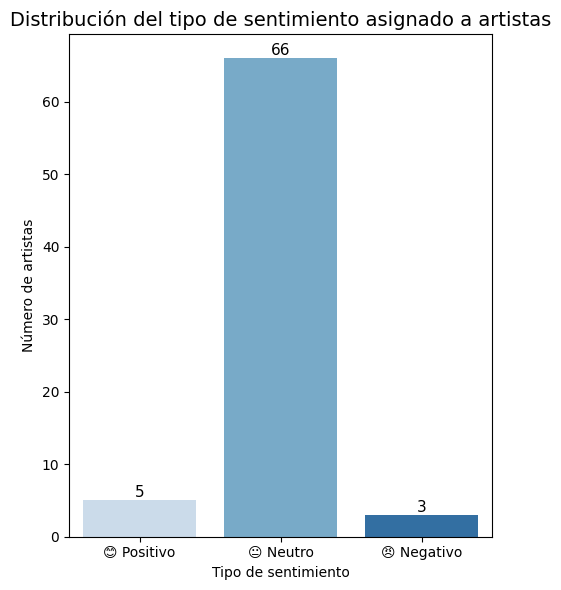

In [155]:
# Obtener distribución de sentimientos desde MongoDB
conteo_sentimientos = artists_collection.aggregate([
    {"$match": {"sentiment": {"$in": ["😊 Positivo", "😐 Neutro", "😠 Negativo"]}}},
    {"$group": {"_id": "$sentiment", "total": {"$sum": 1}}}
])

# Convertimos a DataFrame
df_sentimientos = pd.DataFrame(list(conteo_sentimientos))
df_sentimientos.columns = ['Sentimiento', 'Total']

# Orden personalizado (para que aparezcan en orden lógico)
orden_sentimientos = ["😊 Positivo", "😐 Neutro", "😠 Negativo"]
df_sentimientos['Sentimiento'] = pd.Categorical(df_sentimientos['Sentimiento'], categories=orden_sentimientos, ordered=True)
df_sentimientos = df_sentimientos.sort_values('Sentimiento')

# Paleta en tonos azules
colores = sns.color_palette("Blues", n_colors=3)

# Crear gráfico sin warning (usando hue)
plt.figure(figsize=(5,6))
barplot = sns.barplot(data=df_sentimientos, x='Sentimiento', y='Total', 
                      hue='Sentimiento', palette=colores, legend=False)

# Añadir etiquetas en las barras
for p in barplot.patches:
    barplot.annotate(f'{int(p.get_height())}', 
                     (p.get_x() + p.get_width() / 2, p.get_height()),
                     ha='center', va='bottom', fontsize=11)

# Títulos
plt.title('Distribución del tipo de sentimiento asignado a artistas', fontsize = 14)
plt.ylabel('Número de artistas')
plt.xlabel('Tipo de sentimiento')
plt.tight_layout()
plt.show()

Tras aplicar el análisis de sentimiento a los artistas de nuestra colección, se ha conseguido etiquetar emocionalmente a un **89,2%** de los casos, frente a un **10,8%** para los que no fue posible asignar ninguna etiqueta debido a la falta de información o errores durante el proceso de extracción. Esta alta cobertura inicial sugiere que la estrategia utilizada es eficaz para enriquecer automáticamente la base de datos con metainformación valiosa, basada en procesamiento de lenguaje natural (NLP).

Además, al profundizar en la distribución interna de los **74 artistas que sí fueron etiquetados**, observamos que:

- La **gran mayoría** (66 artistas) recibió una valoración **neutra** 😐
- Solo **5 artistas** fueron clasificados con sentimiento **positivo** 😊
- Y **3 artistas** con sentimiento **negativo** 😠

Esta distribución tan desbalanceada hacia el sentimiento neutro plantea nuevas preguntas analíticas que abren la puerta a investigaciones futuras. Aunque hemos logrado enriquecer más del **85% de la población total**, los resultados sugieren que la fuente de etiquetas (API de Last.fm):

- Ofrece una información emocional limitada o poco polarizada
- O bien que el proceso de extracción actual no captura con suficiente riqueza la carga emocional real de los artistas

**En consecuencia, sería interesante profundizar en:**

- El uso de técnicas de NLP más avanzadas (por ejemplo, modelos tipo BERT o análisis multilingüe)
- La combinación de Last.fm con otras fuentes de información (reseñas, letras de canciones, descripciones más elaboradas)
- El impacto del preprocesamiento de texto, ya que muchas descripciones pueden contener ruido o ambigüedad

Este análisis preliminar nos ha permitido probar la viabilidad técnica de incorporar sentimiento a la base de datos y nos ha revelado nuevos frentes de mejora para aumentar la expresividad y utilidad del sistema de recomendación futura en el bot de Telegram.

## 5. Conclusión

En este notebook se ha implementado un análisis de sentimiento básico a partir de las etiquetas asociadas a artistas en la plataforma Last.fm, integrando esta información en la base de datos MongoDB del proyecto.

Este análisis, aunque sencillo, aporta un valor adicional al sistema, complementando los datos estructurados provenientes de Ticketmaster (como eventos, fechas, ubicaciones, etc.) con una percepción más emocional o colectiva del artista. Esta percepción ha sido inferida a partir del comportamiento y etiquetado de usuarios en una red musical social activa.

El resultado final —una puntuación de polaridad y una etiqueta de sentimiento positivo/neutro/negativo— se almacena directamente en la colección `artists`, y estará disponible para ser consultado por el bot de Telegram que acompaña al sistema. De esta manera, se podrá responder al usuario no solo con fechas de conciertos, sino también con información como:

> 🎶 *Guns N' Roses* tiene una percepción general **neutra** entre los fans de Last.fm.


---
### 📌 Posibilidades futuras

Esta primera integración abre las posibilidades a extenderlo a un buen análisis de sentimiento y enriquecer el sistema con información adicional desde la API de Last.fm, como por ejemplo:

- Número de oyentes mensuales del artista (`artist.getInfo`)
- Canciones más escuchadas (`artist.getTopTracks`)
- Valoraciones o biografía del artista (`artist.getInfo > bio > summary`)
- Comentarios públicos o tags por canción (si se usan `track.getInfo` o `track.getTopTags`)

Toda esta información permitiría, en futuras versiones, alimentar tanto modelos de recomendación como herramientas de exploración o visualización desde el bot de Telegram, ofreciendo una experiencia más personalizada y rica para el usuario.

---



### ✅ Utilidad de los resultados

Este notebook se ha incorporado al proyecto como parte del flujo analítico principal. Gracias a él:

- Se enriquece la colección `artists` con nuevas variables interpretativas.
- Se ofrece un primer acercamiento a análisis de texto y sentimiento.
- Se potencia el uso de fuentes externas para complementar datos de eventos.
- Se allana el camino para sistemas de recomendación más inteligentes e interactivos.